In [273]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from jax import grad
import shap
from xgboost import XGBRegressor
import xgboost as xgb
# TitleProp = fm.FontProperties(fname='/Users/skazi/ML/Fonts/RobotoCondensed-Bold.ttf', size=30)

# Implementing an XGBoost regression model

Tuned model using Bayesian Optimization, GridSearchCV and brute force iteration.

### Read in data

In [125]:
df = pd.read_csv('/Users/seantibbitts/Downloads/Dataframe519.csv', sep='|')

In [127]:
# Drop previous index column
df2 = df.drop('Unnamed: 0', axis = 1)

In [129]:
df2.head()

,YearMakeModel,Price,Mileage,Num_reviews,location,features,specs,stars
0,2009 Hyundai Accent GS,"5,599",87K,38,"Salt Lake City, UT","Rear Spoiler, Overhead Airbags, Side Airbags, ...","4 Cylinders, 2WD, 1.6L Engine, Manual 5 Speed ...",4.5
1,2006 Saturn Ion 2,"5,599",127K,28,"Los Angeles, CA","Cruise Control, Auxiliary Audio Input, Rear Sp...","4 Cylinders, 2WD, 2.2L Engine, Manual 5 Speed ...",4.0
2,2008 Smart Fortwo Pure,"5,599",86K,46,"Los Angeles, CA","Traction Control, Side Airbags, ABS Brakes, Po...","3 Cylinders, 2WD, 1.0L Engine, Automatic Trans...",4.0
3,2010 Hyundai Accent Blue,"5,899",114K,37,"Salisbury, MD","Auxiliary Audio Input, Overhead Airbags, Side ...","4 Cylinders, 2WD, 1.6L Engine, Manual 5 Speed ...",4.5
4,2006 Chevrolet Aveo LS,"5,998",73K,12,"San Diego, CA","AM/FM Stereo, Rear Defroster, Cloth Seats, Man...","4 Cylinders, 2WD, 1.6L Engine, Manual 5 Speed ...",4.5


### Clean data

In [131]:
# 'Price' column is a string with comma separated thousands place
df2['price'] = pd.to_numeric(df2['Price'].str.replace(',',''))

In [138]:
# 'Mileage' is a string with a 'K' appended (should probably multiply by 1,000) and in at least one instance, ='New'
df2['mileage'] = pd.to_numeric(df2['Mileage'].str.replace('K','').str.replace('New','0'))

In [171]:
# Extract number of cylinders from specs where 'Cylinders' occurs preceded by a number
df2['cylinders'] = pd.to_numeric(df2['specs'].str.extract(r'(\d) ?Cylinders')[0])

In [172]:
# Extract drive where 'WD' occurs preceded by a number
df2['drive'] = pd.to_numeric(df2['specs'].str.extract(r'(\d)WD')[0])

In [175]:
# Extract liters of engine where 'L Engine' occurs preceded by a number (possibly decimal)
df2['engine'] = pd.to_numeric(df2['specs'].str.extract(r'(\d?\.?\d)L Engine')[0])

In [182]:
# Set 'transmission' to 'Manual' if 'Manual' occurs; to 'Automatic' if 'Automatic' occurs; else None
df2['transmission'] = df2['specs'].map(lambda x: 'Manual' if 'Manual' in str(x)
                                       else 'Automatic' if 'Automatic' in str(x) else None)

In [197]:
# Extract primary and secondary colors from specs where two words occur separated by a slash
df3 = pd.concat([df2,df2['specs'].str.extract(r'\b(\w+)/(\w+)\b')
                 .rename(columns={0:'prim_color',1:'sec_color'})], axis = 1)

In [209]:
# Join all features together in long comma-separated list then split on commas
# and turn into set to get unique elements
features = set([x.strip() for x in ','.join([str(x) for x in df3['features'].values if pd.notnull(x)]).split(',')])

In [211]:
# One-hot encode features
for feature in features:
    df3[feature] = df3['features'].map(lambda x: 1 if feature in str(x) else 0)

In [220]:
# Extract year
df3['year'] = pd.to_numeric(df3['YearMakeModel'].str.extract(r'\b(\d+)')[0])

In [227]:
# Extract make
df3['make'] = df3['YearMakeModel'].str.extract(r'\b\d+ (\w+-?\w*) ')[0]

In [262]:
# Extract model
df3['model'] = df3['YearMakeModel'].str.extract(r'\b\d+ \w+-?w* (.+)')[0]

In [263]:
# Extract state
df3['state'] = df3['location'].str.extract(r', ([A-Z]{2})\b')[0]

In [264]:
# Extract city
df3['city'] = df3['location'].str.extract(r'([a-zA-Z ]+),')[0]

In [265]:
# Drop unused columns
X_1 = df3.drop(['YearMakeModel','Price','Mileage','location','features','specs','price'], axis = 1).copy()

In [266]:
X_1.head()

,Num_reviews,stars,mileage,cylinders,drive,engine,transmission,prim_color,sec_color,Auxiliary Audio Input,...,Anniversary Edition,Leather Seats,No A/C,Soft Top,Fold-Away Third Row,year,make,model,state,city
0,38,4.5,87,4.0,2.0,1.6,Manual,Red,Black,0,...,0,0,0,0,0,2009,Hyundai,Accent GS,UT,Salt Lake City
1,28,4.0,127,4.0,2.0,2.2,Manual,Gray,Gray,1,...,0,0,0,0,0,2006,Saturn,Ion 2,CA,Los Angeles
2,46,4.0,86,3.0,2.0,1.0,Automatic,White,Black,0,...,0,0,0,0,0,2008,Smart,Fortwo Pure,CA,Los Angeles
3,37,4.5,114,4.0,2.0,1.6,Manual,Silver,Black,1,...,0,0,0,0,0,2010,Hyundai,Accent Blue,MD,Salisbury
4,12,4.5,73,4.0,2.0,1.6,Manual,White,Black,0,...,0,0,1,0,0,2006,Chevrolet,Aveo LS,CA,San Diego


In [267]:
# A few columns have NAs, but XGBoost can handle those
X_1.isna().any()

Num_reviews               False
stars                      True
mileage                   False
cylinders                  True
drive                      True
engine                     True
transmission               True
prim_color                 True
sec_color                  True
Auxiliary Audio Input     False
Ultimate Package          False
Alpine Sound System       False
Sunroof(s)                False
Auto Cruise Control       False
Power Windows             False
Rear Air Conditioning     False
S-Line                    False
Monsoon Sound             False
Long Bed                  False
John Cooper Works Pkg     False
Harman Kardon Sound       False
Full Roof Rack            False
Tow Hitch                 False
DVD Video System          False
Technology Package        False
Running Boards            False
Air Conditioning          False
Z71 Package               False
Hard Top                  False
Side Airbags              False
                          ...  
Traction

In [243]:
# One-hot encode remaining columns
X = pd.get_dummies(X_1)

In [244]:
X.head()

,Num_reviews,stars,mileage,cylinders,drive,engine,Auxiliary Audio Input,Ultimate Package,Alpine Sound System,Sunroof(s),...,city_Town Center,city_Tucson,city_Tulsa,city_Tupelo,city_Twin Cities,city_Virginia Beach,city_Waterbury,city_White Marsh,city_Wichita,city_Woodbridge
0,38,4.5,87,4.0,2.0,1.6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,28,4.0,127,4.0,2.0,2.2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,46,4.0,86,3.0,2.0,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,37,4.5,114,4.0,2.0,1.6,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,12,4.5,73,4.0,2.0,1.6,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Set target and split data

In [245]:
y = df3['price']

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=.5, random_state=42)

### Baseline model

In [271]:
#My baseline model performance

# model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=310, n_jobs=-1, oob_score=True, verbose=3)
model = XGBRegressor(n_estimators=500, max_depth = 5, random_state=310, n_jobs=-1, silent=False)
model.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, eval_metric='rmse')
model.score(X_train, y_train)


[0]	validation_0-rmse:19649.5
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:17799.3
[2]	validation_0-rmse:16145.1
[3]	validation_0-rmse:14657.9
[4]	validation_0-rmse:13322.9
[5]	validation_0-rmse:12141.9
[6]	validation_0-rmse:11078.7
[7]	validation_0-rmse:10129.2
[8]	validation_0-rmse:9277.03
[9]	validation_0-rmse:8517.95
[10]	validation_0-rmse:7846.58
[11]	validation_0-rmse:7252.2
[12]	validation_0-rmse:6716.05
[13]	validation_0-rmse:6233.42
[14]	validation_0-rmse:5815.99
[15]	validation_0-rmse:5447.28
[16]	validation_0-rmse:5121.24
[17]	validation_0-rmse:4835.84
[18]	validation_0-rmse:4582
[19]	validation_0-rmse:4356.51
[20]	validation_0-rmse:4164.58
[21]	validation_0-rmse:3999.61
[22]	validation_0-rmse:3856.16
[23]	validation_0-rmse:3732.47
[24]	validation_0-rmse:3617.61
[25]	validation_0-rmse:3508.01
[26]	validation_0-rmse:3415.81
[27]	validation_0-rmse:3342.56
[28]	validation_0-rmse:3273.38
[29]	validation_0-rmse:3202.4
[30]	validation_0-r

[259]	validation_0-rmse:2001.24
[260]	validation_0-rmse:1999.52
[261]	validation_0-rmse:1996.63
[262]	validation_0-rmse:1996.44
[263]	validation_0-rmse:1994.83
[264]	validation_0-rmse:1993.36
[265]	validation_0-rmse:1990.45
[266]	validation_0-rmse:1989.69
[267]	validation_0-rmse:1988.99
[268]	validation_0-rmse:1987.99
[269]	validation_0-rmse:1985.82
[270]	validation_0-rmse:1985.26
[271]	validation_0-rmse:1984.49
[272]	validation_0-rmse:1983.09
[273]	validation_0-rmse:1982.28
[274]	validation_0-rmse:1981.54
[275]	validation_0-rmse:1980.77
[276]	validation_0-rmse:1979.79
[277]	validation_0-rmse:1978.92
[278]	validation_0-rmse:1978.07
[279]	validation_0-rmse:1975.89
[280]	validation_0-rmse:1974.91
[281]	validation_0-rmse:1974.37
[282]	validation_0-rmse:1973.21
[283]	validation_0-rmse:1971.61
[284]	validation_0-rmse:1968.83
[285]	validation_0-rmse:1967.99
[286]	validation_0-rmse:1967.5
[287]	validation_0-rmse:1966.05
[288]	validation_0-rmse:1965.73
[289]	validation_0-rmse:1964.91
[290]	val

0.9646842269740333

In [272]:
model.score(X_test, y_test)

0.9555548431301689

### Use SHAP values to investigate feature relevance
#### (following procedure from here: https://github.com/slundberg/shap)

In [ ]:
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

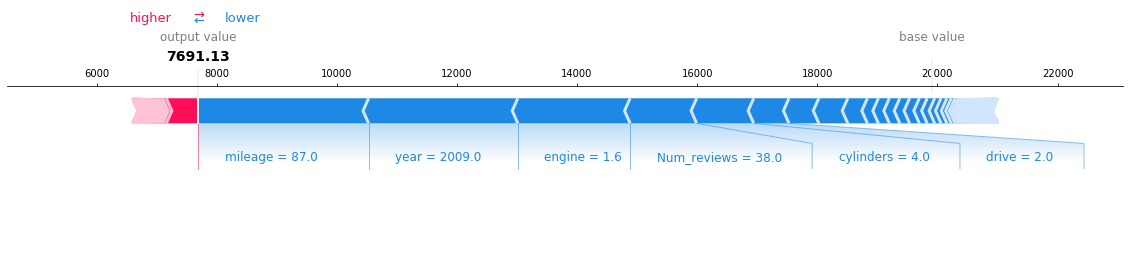

In [275]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:], matplotlib=True)

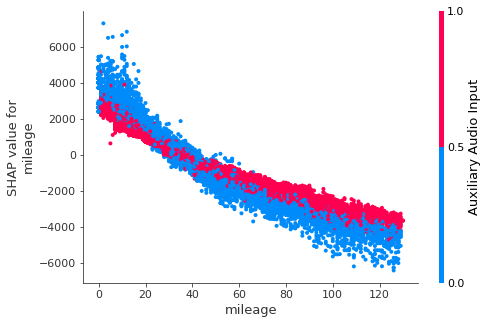

In [277]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("mileage", shap_values, X)

### Select most relevant columns

In [295]:
num_cols = 100

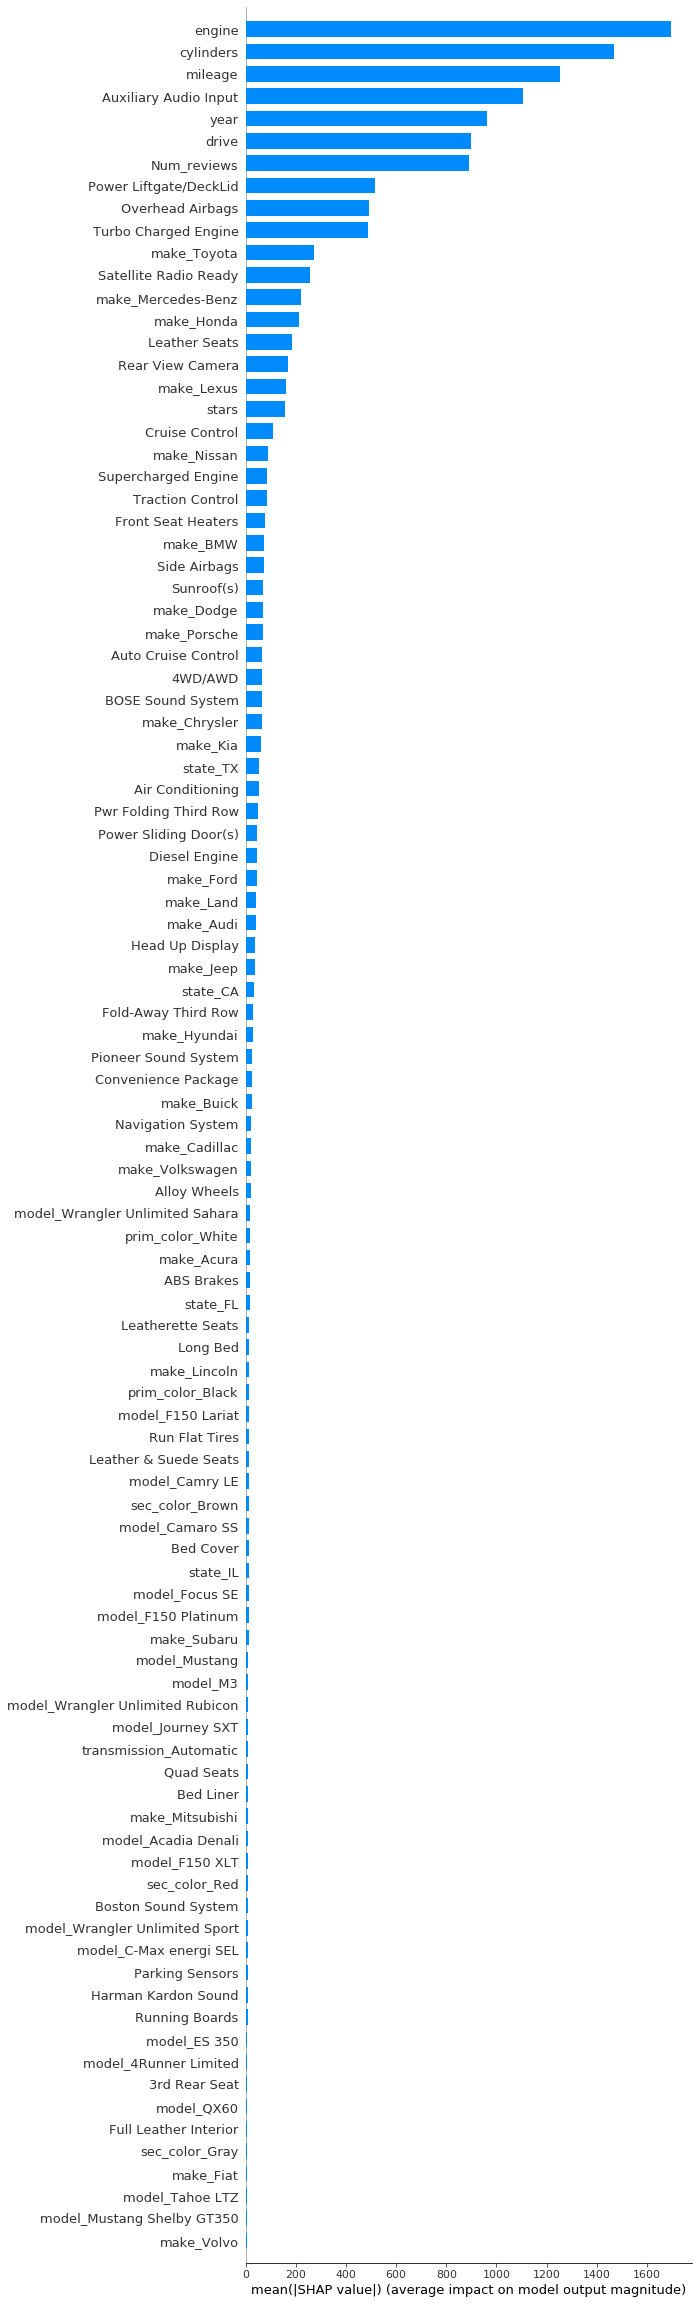

In [280]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X, plot_type='bar', max_display=num_cols)

In [297]:
keep_cols = list(map(lambda x: x[0], sorted(list(zip(X.columns,np.abs(shap_values).mean(axis=0))),
                                key = lambda x: -x[1])[:num_cols]))

In [299]:
X[keep_cols].head()

,engine,cylinders,mileage,Auxiliary Audio Input,year,drive,Num_reviews,Power Liftgate/DeckLid,Overhead Airbags,Turbo Charged Engine,...,model_ES 350,model_4Runner Limited,3rd Rear Seat,model_QX60,Full Leather Interior,sec_color_Gray,make_Fiat,model_Tahoe LTZ,model_Mustang Shelby GT350,make_Volvo
0,1.6,4.0,87,0,2009,2.0,38,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2.2,4.0,127,1,2006,2.0,28,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1.0,3.0,86,0,2008,2.0,46,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.6,4.0,114,1,2010,2.0,37,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1.6,4.0,73,0,2006,2.0,12,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Set Up Bayesian Optimization

In [303]:
folds = 5

dtrain = xgb.DMatrix(X_train[keep_cols], label = y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [307]:
params = {
        'eval_metric':'rmse',
        'eta':0.1,
        'nthread':4
    }

In [325]:
def objective_xgb(min_child_weight, gamma, subsample, colsample_bytree, max_depth):
    params = {
        'eval_metric':'rmse',
        'min_child_weight': int(min_child_weight),
        'gamma': gamma,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'max_depth': int(max_depth),
        'eta':0.1,
        'nthread':4
    }
    
    xmodelcv = xgb.cv(params = params, dtrain = dtrain, nfold = folds, num_boost_round=10000,
                      early_stopping_rounds=100,
                      seed = 42
                     )
    
    best_score = -xmodelcv['test-rmse-mean'].iloc[-1]
    
    return best_score

In [326]:
pbounds = {
        'min_child_weight': (1, 10),
        'gamma': (.5, 5),
        'subsample': (0.6, 1.0),
        'colsample_bytree': (0.3, 1.0),
        'max_depth': (3, 10)
        }

In [327]:
from bayes_opt import BayesianOptimization

In [328]:
optimizer = BayesianOptimization(objective_xgb, pbounds, random_state = 42, verbose = 3)

### Run Bayesian Optimization

In [329]:
optimizer.maximize(init_points=0, n_iter=1)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
|  1        | -1.697e+0 |  0.5622   |  4.778    |  8.124    |  6.388    |  0.6624   |
|  2        | -1.779e+0 |  0.9743   |  0.5137   |  3.199    |  1.005    |  0.725    |


In [ ]:
optimizer.maximize()

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
|  3        | -1.682e+0 |  0.4092   |  0.7614   |  9.063    |  6.41     |  0.8832   |
|  4        | -1.685e+0 |  0.3144   |  4.865    |  8.827    |  2.911    |  0.6727   |
|  5        | -1.669e+0 |  0.4284   |  1.869    |  6.673    |  4.888    |  0.7165   |
|  6        | -1.675e+0 |  0.7283   |  1.128    |  5.045    |  4.297    |  0.7824   |
|  7        | -1.686e+0 |  0.8496   |  1.399    |  6.6      |  6.332    |  0.6186   |
|  8        | -1.671e+0 |  0.4861   |  1.694    |  6.327    |  4.736    |  0.7389   |
|  9        | -1.669e+0 |  0.424    |  1.802    |  6.754    |  4.882    |  0.7206   |
|  10       | -1.678e+0 |  0.3994   |  1.904    |  6.693    |  4.814    |  0.6711   |
|  11       | -1.675e+0 |  0.439    |  1.818    |  6.691    |  4.906    |  0.7358   |
|  12       | -1.68e+03 |  0.4204   |  1.849    |  6.7

In [332]:
len(optimizer.space)

22

In [334]:
# model = RandomForestRegressor(n_estimators=500, max_depth=5, random_state=310, n_jobs=-1, oob_score=True, verbose=3)
model = XGBRegressor(n_estimators=500, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371, max_depth=6, min_child_weight=4)

In [336]:
model.fit(X_train[keep_cols], y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.4766, gamma=1.61, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=4, missing=None, n_estimators=500, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=310,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=0.9371)

In [337]:
model.score(X_test[keep_cols], y_test)

0.9630399298665678

### Do grid search on integer-valued parameters

In [339]:
param_grid = {
    'min_child_weight': [1, 3, 5, 7, 9],
    'max_depth': [3, 4, 5, 7, 8, 9, 10]
}

In [340]:
reg = XGBRegressor(n_estimators=500, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371)

In [341]:
grid = GridSearchCV(reg, param_grid=param_grid, n_jobs=-1, cv=5, verbose = 3)

In [342]:
grid.fit(X_train[keep_cols],y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed: 42.4min finished
/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1,
                                    colsample_bytree=0.4766, gamma=1.61,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=500, n_jobs=-1, nthread=None,
                                    objective='reg:linear', random_state=310,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=False,
                                    subsample=0.9371),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 7, 8, 9, 10],
                         'min_child_weight': [1, 3, 5, 7, 9]},
             pr

In [343]:
grid.best_params_

{'max_depth': 9, 'min_child_weight': 1}

In [344]:
grid.best_estimator_.score(X_test[keep_cols], y_test)

0.9667406526570769

### Figure out how many columns to include
#### Sort using SHAP values

In [346]:
col_importance = list(map(lambda x: x[0], sorted(list(zip(X.columns,np.abs(shap_values).mean(axis=0))),
                                key = lambda x: -x[1])))

In [349]:
len(col_importance)

2067

In [354]:
n_cols = [10, 50, 200, 500, 1000, 2067]

In [355]:
settings = []
for col in n_cols:
    print(f'n_cols: {col}')
    cols = col_importance[:col]
    reg_col = XGBRegressor(n_estimators=500, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371)
    print(f'Fit to XGBoost')
    reg_col.fit(X_train[cols], y_train)
    print(f'Score model')
    score = reg_col.score(X_test[cols], y_test)
    these_params = {'n_cols':col, 'score':score}
    print(f'Save parameters')
    settings.append(these_params)

n_cols: 10
Fit to XGBoost
Score model
Save parameters
n_cols: 50
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
n_cols: 200
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
n_cols: 500
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
n_cols: 1000
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
n_cols: 2067
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters


In [360]:
num_cols = pd.DataFrame(settings).sort_values('score', ascending = False).iloc[0,0]

In [361]:
keep_cols = col_importance[:num_cols]

### Run Bayesian Optimization again to find L1 regularization

In [368]:
dtrain = xgb.DMatrix(X_train[keep_cols], label = y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [369]:
def objective_alpha(alpha):
    params = {
        'eval_metric':'rmse',
        'min_child_weight': 1,
        'gamma': 1.61,
        'subsample': 0.9371,
        'colsample_bytree': 0.4766,
        'max_depth': 9,
        'alpha':alpha,
        'eta':0.1,
        'nthread':4
    }
    
    xmodelcv = xgb.cv(params = params, dtrain = dtrain, nfold = folds, num_boost_round=100,
                      early_stopping_rounds=10,
                      seed = 42
                     )
    
    best_score = -xmodelcv['test-rmse-mean'].iloc[-1]
    
    return best_score

In [370]:
pbounds_alpha = {'alpha':(1e-05,10)}

In [371]:
optimizer_alpha = BayesianOptimization(objective_alpha, pbounds_alpha, random_state = 42, verbose = 3)

In [372]:
optimizer_alpha.maximize(n_iter=10)

|   iter    |  target   |   alpha   |
-------------------------------------
|  1        | -1.848e+0 |  3.745    |
|  2        | -1.854e+0 |  9.507    |
|  3        | -1.854e+0 |  7.32     |
|  4        | -1.853e+0 |  5.987    |
|  5        | -1.847e+0 |  1.56     |
|  6        | -1.849e+0 |  2.438    |
|  7        | -1.849e+0 |  1.118    |
|  8        | -1.847e+0 |  1.815    |
|  9        | -1.845e+0 |  1.662    |
|  10       | -1.846e+0 |  1.706    |
|  11       | -1.846e+0 |  1.676    |
|  12       | -1.845e+0 |  1.624    |
|  13       | -1.846e+0 |  1.746    |
|  14       | -1.845e+0 |  1.642    |
|  15       | -1.847e+0 |  1.603    |


In [379]:
xgb_alpha = XGBRegressor(n_estimators=500, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371, min_child_weight=1, max_depth=9,
                         reg_alpha=1.624)

In [380]:
xgb_alpha.fit(X_train[keep_cols], y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.4766, gamma=1.61, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=310,
             reg_alpha=1.624, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=0.9371)

In [381]:
xgb_alpha.score(X_test[keep_cols], y_test)

0.9714093329344152

In [382]:
xgb_no_alpha = XGBRegressor(n_estimators=500, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371, min_child_weight=1, max_depth=9,
                         reg_alpha=0)

In [383]:
xgb_no_alpha.fit(X_train[keep_cols],y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.4766, gamma=1.61, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=310,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=0.9371)

In [384]:
xgb_no_alpha.score(X_test[keep_cols], y_test)

0.9711390082614837

### ... and again to find L2 regularization

In [391]:
pbounds_lambda = {'lamb':(1e-05,10)}

In [392]:
def objective_lambda(lamb):
    params = {
        'eval_metric':'rmse',
        'min_child_weight': 1,
        'gamma': 1.61,
        'subsample': 0.9371,
        'colsample_bytree': 0.4766,
        'max_depth': 9,
        'alpha':1.624,
        'eta':0.1,
        'nthread':4,
        'lambda':lamb
    }
    
    xmodelcv = xgb.cv(params = params, dtrain = dtrain, nfold = folds, num_boost_round=100,
                      early_stopping_rounds=10,
                      seed = 42
                     )
    
    best_score = -xmodelcv['test-rmse-mean'].iloc[-1]
    
    return best_score

In [393]:
optimizer_lambda = BayesianOptimization(objective_lambda, pbounds_lambda, random_state = 42, verbose = 3)

In [395]:
optimizer_lambda.maximize(n_iter=10)

|   iter    |  target   |   lamb    |
-------------------------------------
|  1        | -2.022e+0 |  9.507    |
|  2        | -2.001e+0 |  7.32     |
|  3        | -1.973e+0 |  5.987    |
|  4        | -1.869e+0 |  1.56     |
|  5        | -1.868e+0 |  1.56     |
|  6        | -1.835e+0 |  0.5808   |
|  7        | -2.012e+0 |  8.662    |
|  8        | -1.98e+03 |  6.011    |
|  9        | -1.995e+0 |  7.081    |
|  10       | -1.832e+0 |  0.5809   |
|  11       | -1.832e+0 |  0.581    |
|  12       | -1.832e+0 |  0.5809   |
|  13       | -1.832e+0 |  0.5809   |
|  14       | -1.868e+0 |  1.56     |
|  15       | -1.832e+0 |  0.581    |
|  16       | -1.835e+0 |  0.5809   |
|  17       | -1.832e+0 |  0.5809   |
|  18       | -1.832e+0 |  0.5809   |
|  19       | -1.834e+0 |  0.581    |


In [399]:
optimizer_lambda.space.target

array([-2021.5298828, -2000.572534 , -1973.3593018, -1868.5729248,
       -1868.1587402, -1835.2709962, -2011.8776368, -1979.6970948,
       -1994.7603758, -1832.2723146, -1832.273926 , -1832.2729492,
       -1831.557373 , -1868.1585694, -1832.2894532, -1834.556128 ,
       -1832.271167 , -1832.2731446, -1833.6808838])

In [409]:
max_lamb = optimizer_lambda.max['params']['lamb']

In [410]:
xgb_lambda = XGBRegressor(n_estimators=500, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371, min_child_weight=1, max_depth=9,
                         reg_alpha=1.624, reg_lambda = max_lamb)

In [411]:
xgb_lambda.fit(X_train[keep_cols], y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.4766, gamma=1.61, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=310,
             reg_alpha=1.624, reg_lambda=0.5809073944978933, scale_pos_weight=1,
             seed=None, silent=False, subsample=0.9371)

In [412]:
xgb_lambda.score(X_test[keep_cols], y_test)

0.9713642311617919

In [413]:
xgb_no_lambda = XGBRegressor(n_estimators=500, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371, min_child_weight=1, max_depth=9,
                         reg_alpha=1.624, reg_lambda = 1)

In [415]:
xgb_no_lambda.fit(X_train[keep_cols], y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.4766, gamma=1.61, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=310,
             reg_alpha=1.624, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=0.9371)

In [416]:
xgb_no_lambda.score(X_test[keep_cols], y_test)

0.9714093329344152

### Find optimal number of components

In [417]:
no_components = [10, 50, 100, 250, 750, 1000]

In [418]:
settings_comp = []
for comp in no_components:
    print(f'no_components: {comp}')
    print(f'Define model')
    xgb_comp = XGBRegressor(n_estimators=comp, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371, min_child_weight=1, max_depth=9,
                         reg_alpha=1.624, reg_lambda = 1)
    print(f'Fit to XGBoost')
    xgb_comp.fit(X_train[keep_cols], y_train)
    print(f'Score model')
    score = xgb_comp.score(X_test[keep_cols], y_test)
    these_params = {'no_components':comp, 'score':score}
    print(f'Save parameters')
    settings_comp.append(these_params)

no_components: 10
Define model
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
no_components: 50
Define model
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
no_components: 100
Define model
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
no_components: 250
Define model
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
no_components: 500
Define model
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters
no_components: 1000
Define model
Fit to XGBoost


/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Score model
Save parameters


In [419]:
pd.DataFrame(settings_comp)

,no_components,score
0,10,0.046979
1,50,0.945525
2,100,0.957037
3,250,0.967341
4,500,0.971409
5,1000,0.973320


In [420]:
xgb_final = XGBRegressor(n_estimators=1000, random_state=310, n_jobs=-1, silent=False,
                     colsample_bytree=0.4766, gamma=1.61, subsample=0.9371, min_child_weight=1, max_depth=9,
                         reg_alpha=1.624, reg_lambda = 1)

In [421]:
xgb_final.fit(X_train[keep_cols], y_train)

/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.4766, gamma=1.61, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=9,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
             nthread=None, objective='reg:linear', random_state=310,
             reg_alpha=1.624, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=0.9371)

In [422]:
xgb_final.score(X_test[keep_cols], y_test)

0.9733203536677457

In [423]:
xgb_final.score(X_valid[keep_cols], y_valid)

0.9678931372760962